In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

Заказчик попросил проанализировать данные и ответить на следующие вопросы:

1. Сколько пользователей, которые совершили покупку только один раз?  [Перейти к Решению](#title1)  
2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? [Перейти к Решению](#title2)
3. По каждому товару определить, в какой день недели товар чаще всего покупается. [Перейти к Решению](#title3)
4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? [Перейти к Решению](#title4)
5. Провести когортный анализ пользователей. В период с января по декабрь выявить когорту с самым высоким retention на 3й месяц. [Перейти к Решению](#title5)
6. Построить RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. [Перейти к Решению](#title6)


 ### <a id="title0">Данные</a> 

1. **customers** — таблица с уникальными идентификаторами пользователей
    - customer_id — позаказный идентификатор пользователя
    - customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)
    - customer_zip_code_prefix —  почтовый индекс пользователя
    - customer_city —  город доставки пользователя
    - customer_state —  штат доставки пользователя
    
    
2. **orders** —  таблица заказов
    - order_id —  уникальный идентификатор заказа (номер чека)
    - customer_id —  позаказный идентификатор пользователя
    - order_status —  статус заказа
        * *created —  создан*
        * *approved —  подтверждён*
        * *invoiced —  выставлен счёт*
        * *processing —  в процессе сборки заказа*
        * *shipped —  отгружен со склада*
        * *delivered —  доставлен пользователю*
        * *unavailable —  недоступен*
        * *canceled —  отменён*
    - order_purchase_timestamp —  время создания заказа
    - order_approved_at —  время подтверждения оплаты заказа
    - order_delivered_carrier_date —  время передачи заказа в логистическую службу
    - order_delivered_customer_date —  время доставки заказа
    - order_estimated_delivery_date —  обещанная дата доставки
    
    
3. **order_items** —  товарные позиции, входящие в заказы
    - order_id —  уникальный идентификатор заказа (номер чека)
    - order_item_id —  идентификатор товара внутри одного заказа
    - product_id —  ид товара (аналог штрихкода)
    - seller_id — ид производителя товара
    - shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
    - price —  цена за единицу товара
    - freight_value —  вес товара

Первое, с чем необходимо было разобраться — это наладить бесшовный импорт файлов из хранилища на Яндекс Диске. Ссылки на скачивание файлов не работают, а ссылки на сами файлы временные и обновляются, пришлось бы при каждой загрузке вставлять их новые адреса в команды для считывания файла.   

Решение:   
    - Загрузила библиотеки для работы сo ссылками, запросами и файлами типа json. 
    - Поместила ссылки на страницы скачивания файлов в список links. 
    - Проитерировалась по списку и создала ссылки для запроса, сделала запрос. Далее из json файла, который является словарём, вытащила финальные ссылки по ключу 'file' и поместила их уже в новый список final_links. 
    - В запросе на чтение csv уже ссылалась на индексы нового списка.

In [2]:
import requests
from urllib.parse import urlencode
import json

In [3]:
public_link_customers = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg'
public_link_orders = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw'
public_link_order_items = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'

In [4]:
links = [public_link_customers, public_link_orders, public_link_order_items]

In [5]:
final_links = []
for link in links:
    resources = "https://cloud-api.yandex.net/v1/disk/public/resources?"
    requests_url = resources + urlencode(dict(public_key=link))
    r =  requests.get(requests_url)
    final_url = r.json()['file']
    final_links.append(final_url)

In [6]:
customers = pd.read_csv(final_links[0])

In [7]:
order_items = pd.read_csv(final_links[-1])

In [8]:
orders = pd.read_csv(final_links[1])

In [9]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [10]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [11]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


В датасете с таблицей заказов 'orders' есть пропущенные значения в колонках *order_approved_at*, *order_delivered_carrier_date*, *order_delivered_customer_date*. По 160 заказам не была подтверждена оплата, в 1783 случаях не было определено время передачи заказа в логистическую службу, а для 2965 заказов не произошла доставка товаров.  
По первоначальному анализу можно сказать, что:  
**160** заказов **не оплачены**, соответственно их сбор не начался, т.к. нет подтверждения    
**1623** заказа **не собраны**, поэтому не определена дата передачи товаров в логистику  
**1182** заказа были переданы в доставку, но **не доставлены**

In [12]:
orders.order_approved_at.isna().sum()

160

In [13]:
orders.order_delivered_carrier_date.isna().sum()

1783

In [14]:
orders.order_delivered_customer_date.isna().sum()

2965

### <a id="title1">1. Для того, чтобы выяснить, сколько у нас пользователей, которые совершили покупку только 1 раз:</a>  
    * необходимо выяснить уникальный id для кажого покупателя: к данным по заказам в таблице orders присоединю данные покупателей, общей колонкой возьму показанный идентификатор пользователя customer_id  
    * совершёнными могут считаться только заказы в статусе 'delivered': сгруппирую данные по уникальному id, отберу доставленные заказы и посчитаю количество пользователей, для которых количество таких заказов равняется единице  
    
   [Перейти к описанию данных](#title0)

In [15]:
orders_customers = orders.merge(customers, how='inner', on='customer_id')

In [16]:
orders_customers.query('order_status == "delivered"').groupby('customer_unique_id').order_id.count().value_counts().head(1)

1    90557
Name: order_id, dtype: int64

### <a id="title2">2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?</a>    
   * Если мы анализируем заказы в рамках месяца, то недоставленными могут считаться любые заказы, которые не попали фактически к потребителю на конец месяца. Есть причины-процессы: created, approved, invoiced, processing и shipped. А вот заказы со статусом unavailable и canceled — это уже результаты. 
   * Для того, чтобы удобнее было аггрегировать данные по временным рамкам, задала индексы по первой дате в нашей таблице с заказами, а именно по дате заказа. Количество уникальных заказов показывает, что для каждого заказа у нас выделена отдельная строка, которая не дублируется. Значит, в процессе работы с заказом меняется его статус и добавляется время смены статуса заказа в колонки с временными метками.
   * Далее я отсортировала все заказы по статусу, кроме тех, чей статус "delivered", объединила время в месяцы, посчитала среднее количество. 
   * Для того, чтобы иметь представление о причинах более наглядно, я визуализировала данные в интерактивный график, где можно выбирать целевые статусы для анализа и смотреть их динамику. Ниже я визуализировала общее количество заказов, чтобы отслеживать тренд.  
    
Проанализируем каждую причину отдельно (см.[График](#line_chart_1)):  
   1. *Created* — в ноябре и декабре 2017 года было создано по два заказа, которые, судя по данным, не получили подтверждение.
   2. *Approved* — в феврале и апреле 2017 года по одному заказу получили подтверждение, после этого изменений статуса не последовало, то есть заказы был приняты, но счета не выставлены. Есть предположение, что это может быть техническая ошибка, ошибка в данных или ошибка сотрудника.  
   3. *Invoiced* — есть заказы, по которым выставленные счета не были оплачены. Рост таких счетов пришёлся на пик продаж в ноябре 2017 года, что вполне ожидаемо.  
   4. *Processing* — часть заказов длительно находится в процессе сборки. Цифры незначительные, однако если это действительно несобранные, но оплаченные заказы, то это может негативно сказаться на опыте покупателей. 
   5. *Shipped* — заказы, которые находятся в процессе доставки. Заказы с таким статусом встречаются на протяжении всей истории наблюдений. Наличие таких заказов тоже негативно влияет на клиентский опыт. Здесь, как и во всех вышеуказанных статусах не исключены ошибки в данных и ошибки сотрудников.  
   6. Заказов со статусами *unavailable* и *canceled* практически поровну. Пик статуса *unavailable* пришёлся на месяц самых активных продаж. Возможно основной причиной была возросшая нагрузка на ресурсы склада. Важно то, что после этого пика количество заказов с таким статусом снижается, несмотря на то, что продажи не изменились так кардинально. Вероятно, что качественная работа над остатками, вместимостью склада проведена, а компетенция сотрудников сборки выросла. 
   7. *Canceled* — количество отменённых заказов выросло, спустя три месяца после ноябрьского пика. Возможно, это заказы, которые не были качественно отработаны в срок. Беспокойство вызывает возросшее количество отменённых заказов в августе 2018 года, на этот период приходится пик отмен — 84 заказа. Доля от общего количества небольшая 1,3%, однако наблюдается резкий тренд. Здесь рекомендую обратить внимание на всю цепочку процессов и особенно время в этой цепочке. Такой показатель, как 'waiting time' играет одну из ключевых ролей в удовлетворенности покупателей. На [секторной диаграмме](#pie_chart_1) показаны финальные статусы отменённых заказов. Из 625 заказов 22.6% были отменены до подтверждения заказа, 65.4% на этапе сборки, 11% в процессе доставки и менее 1% после получения товара клиентом. 

   [Перейти к описанию данных](#title0)

In [17]:
orders.order_id.nunique()

99441

In [18]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

In [19]:
order_status = orders.set_index('order_purchase_timestamp')

In [20]:
order_status.query('order_status != "delivered"') \
            .groupby('order_status') \
            .resample(rule='M') \
            .agg({'order_id': 'count'}) \
            .pivot_table(index='order_purchase_timestamp', columns='order_status', values='order_id') \
            .fillna(0) \
            .reset_index().mean()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


order_status
approved        0.076923
canceled       24.038462
created         0.192308
invoiced       12.076923
processing     11.576923
shipped        42.576923
unavailable    23.423077
dtype: float64

In [21]:
order_status.groupby('order_status', as_index=False).agg({'order_id': 'count'}).sort_values(by='order_id', ascending=False)

order_status  order_id
3    delivered     96478
6      shipped      1107
1     canceled       625
7  unavailable       609
4     invoiced       314
5   processing       301
2      created         5
0     approved         2

In [22]:
statuses = order_status.query('order_status != "delivered"') \
            .groupby('order_status') \
            .resample(rule='M') \
            .agg({'order_id': 'count'}).reset_index().fillna(0)

<a id='line_chart_1'></a>

In [91]:
fig = px.line(statuses, 
              x='order_purchase_timestamp', 
              y='order_id', 
              line_group='order_status', 
              color='order_status', 
              title='Order Statuses',
              template='simple_white', 
              color_discrete_sequence =['#4D3C77', '#000033', '#9999CC', '#CC99CC', '#330033', '#897F85', '#BA4E8F'],
              labels={'order_purchase_timestamp': 'Date', 'order_id': 'The number of orders', 'order_status': 'Order status:'})
fig.update_layout(width=900, height=400)
fig.update_xaxes(nticks=28, tickangle=270)
fig.show()

In [24]:
all_orders = order_status \
            .resample(rule='M') \
            .agg({'order_id': 'count'}).reset_index().fillna(0)

In [25]:
fig = px.line(all_orders, 
              x='order_purchase_timestamp', 
              y='order_id', 
              title='Total Orders',
              template='simple_white',
              color_discrete_sequence =['#4D3C77'],
              labels={'order_purchase_timestamp': 'Date', 'order_id': 'The number of orders'})
fig.update_layout(width=900, height=400)
fig.update_xaxes(nticks=28, tickangle=270)
fig.show()

In [26]:
status_of_canceled_orders = order_status.reset_index().query('order_status == "canceled"') \
            .groupby('order_status') \
            .agg({'order_purchase_timestamp': 'count', 
                  'order_approved_at': 'count', 
                  'order_delivered_carrier_date': 'count', 
                  'order_delivered_customer_date': 'count', 
                  'order_estimated_delivery_date': 'count'}) \
            .reset_index() \
            .melt() \
            .drop(0).drop(5) \
            .rename(columns={'variable': 'final_status', 'value': 'canceled_orders'})

In [27]:
status_of_canceled_orders['status_count'] = status_of_canceled_orders.canceled_orders.diff(-1).fillna(status_of_canceled_orders.canceled_orders)

In [28]:
status_of_canceled_orders

final_status canceled_orders  status_count
1       order_purchase_timestamp             625           141
2              order_approved_at             484           409
3   order_delivered_carrier_date              75            69
4  order_delivered_customer_date               6             6

<a id='pie_chart_1'></a>

In [29]:
fig = px.pie(status_of_canceled_orders, 
             names=status_of_canceled_orders.final_status, 
             values=status_of_canceled_orders.status_count, 
             title='Final statuses of cancelled orders', 
             color_discrete_sequence =['#E19898', '#A2678A', '#4D3C77', '#3F1D38'])
fig.update_layout(width=900, height=400)
fig.show()

#### Waiting time
Для анализа waitig time нам понадобятся дополнительные параметры:  
wt_approve — время между заказом и подтверждением  
wt_delivered_carrier — врмемя между подтверждением и передачей в доставку (время сборки)  
wt_delivered_customer — время, затраченное на доставку товара от склада к клиенту  
estimated_delivery_time — обещанное ожидание доставки товара  
actual_delivery_time — общее время ожидания между заказом товара и вручением покупателю  

На графиках, построенных ниже видно, как менялся период доставки товара. В сентябре и октябре 2016 года вероятно происходили продажи в тестовом режиме, заказов было мало, время ожидания на всех этапах длительное. В ноябре и декабре 2016 продаж не было. Повторный запуск произошёл в январе 2017 года. Доставка во всем периоде продаж, кроме тестовых, происходила с опережением обещанного времени. Периодически обещанное время снижалось и возрастало. Пики роста обещанного времени предвосхищало увеличение времени фактической доставки. Однако в июне 2018 года наблюдался всплеск времени обещанной доставки (в среднем 28 дней) при тенденции к снижению фактичекого времени доставки (9 дней). Следом за этим начался рост отмененных заказов. Это может быть связано между собой, так как увеличение времени ожидания товаров может повлечь за собой отказ от покупки. 

   [Перейти к описанию данных](#title0)

In [30]:
orders[['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']] = orders[['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']].apply(pd.to_datetime)

In [31]:
orders['wt_approve'] = orders.order_approved_at - orders.order_purchase_timestamp
orders['wt_delivered_carrier'] = orders.order_delivered_carrier_date - orders.order_approved_at
orders['wt_delivered_customer'] = orders.order_delivered_customer_date - orders.order_delivered_carrier_date
orders['estimated_delivery_time'] = orders.order_estimated_delivery_date - orders.order_purchase_timestamp
orders['actual_delivery_time'] = orders.order_delivered_customer_date - orders.order_purchase_timestamp

In [32]:
orders['wt_approve'] = round(orders.wt_approve.apply(lambda x: x.total_seconds()) / 86400, 1)
orders['wt_delivered_carrier'] = round(orders.wt_delivered_carrier.apply(lambda x: x.total_seconds()) / 86400, 1)
orders['wt_delivered_customer'] = round(orders.wt_delivered_customer.apply(lambda x: x.total_seconds()) / 86400, 1)
orders['estimated_delivery_time'] = round(orders.estimated_delivery_time.apply(lambda x: x.total_seconds()) / 86400, 1)
orders['actual_delivery_time'] = round(orders.actual_delivery_time.apply(lambda x: x.total_seconds()) / 86400, 1)

In [33]:
waiting_time = orders.groupby(orders.order_purchase_timestamp.dt.to_period("M")) \
                     .agg({'wt_approve': 'mean', 'wt_delivered_carrier': 'mean', 
                           'wt_delivered_customer': 'mean'}) \
                     .reset_index() \
                     .melt(id_vars=['order_purchase_timestamp'], 
                           value_vars=['wt_approve', 
                                       'wt_delivered_carrier', 
                                       'wt_delivered_customer'], 
                           var_name='waiting_time', 
                           value_name='average_days')

In [34]:
waiting_time['order_purchase_timestamp'] = waiting_time.order_purchase_timestamp.astype(str)

In [35]:
fig = px.bar(waiting_time, 
             x='order_purchase_timestamp', 
             y='average_days', 
             color='waiting_time', 
             template='simple_white', 
             color_discrete_sequence =['#3F1D38', '#4D3C77', '#A2678A'],
             labels={'order_purchase_timestamp': 'Date', 'average_days': 'Average days', 'waiting_time': 'Waiting time'})
fig.update_layout(autosize=True)
fig.update_xaxes(nticks=28, tickangle=270)
fig.show()

In [36]:
expected_time = orders.groupby(orders.order_purchase_timestamp.dt.to_period("M")) \
                     .agg({'estimated_delivery_time': 'mean', 'actual_delivery_time': 'mean'}) \
                     .reset_index() 

In [37]:
expected_time['order_purchase_timestamp'] = expected_time.order_purchase_timestamp.astype(str)

In [38]:
fig = px.line(expected_time, 
              x='order_purchase_timestamp', 
              y=['estimated_delivery_time', 'actual_delivery_time'], 
              title='Comparison of estimated and actual delivery time',
              template='simple_white',
              color_discrete_sequence =['#E19898', '#4D3C77'],
              labels={'order_purchase_timestamp': 'Date', 'value': 'Average days'})
fig.update_layout(width=900, height=500)
fig.update_xaxes(nticks=28, tickangle=270)
fig.update_yaxes(nticks=20)
fig.show()

### <a id="title3">3. По каждому товару определить, в какой день недели товар чаще всего покупается.</a>

Для начала необходимо определить, что такое **покупка**. Типичная цепочка заказа: создание, оплата, сборка, доставка, вручение. Купленным может считаться товар, который находится в оплаченном заказе. Тогда этот товар снимается с доступного для продажи остатка и с ним происходят дальнейшие действия: сборка, упаковка, доставка. То есть оплату заказа буду считать фактом продажи, что в целом соответствует законодательству нашей страны.  

1. Здесь необходимо добавить из таблицы с заказами время покупки для определения дня недели и статус, чтобы в итоговый результат не попали отмененные заказы. 
2. Добавить колонку с названием дня недели
3. Убрать отмененные заказы, сгруппировать по дню недели и id продукта, посчитать количество покупок, развернуть таблицу и убрать мультииндекс для удобства подсчёта, выбрать максимальное значение в строке продукта на пересечении с днём недели и вывести результат.
   [Перейти к описанию данных](#title0)

In [39]:
products = order_items.merge(orders[['order_purchase_timestamp', 'order_approved_at', 'order_status', 'order_id']], how='inner', on='order_id')

In [40]:
products['day_name'] = products.order_purchase_timestamp.apply(lambda x: x.strftime('%A'))

In [41]:
max_sale_by_dow = products.query('order_approved_at != "NaN"') \
            .groupby(['day_name', 'product_id']) \
            .agg({'order_id': 'count'}) \
            .unstack() \
            .idxmax(axis=0) \
            .to_frame() \
            .reset_index() \
            .drop(columns='level_0') \
            .rename(columns={0: 'day_of_week'})
max_sale_by_dow.sample()

product_id day_of_week
21822  aa68f61c9b2dbcd9cce6c45e80dfbff7      Monday

### <a id="title4">4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?</a> 

Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.  
1. Взяла уже созданный ранее датафрейм, в котором есть данные заказов и пользователей. Определила количество дней в месяце наблюдения: для этого привела даты в датафрейме к необходимому формату и через применение анонимной функции произвела расчёт в новой колонке.  
2. Сгруппировала данные по месяцу и году, посчитала количество оплаченных заказов для каждого уникального пользователя.
3. Разделила количество заказов в месяц для каждого уникального пользователя на количество недель в месяце.

Покупатели обычно совершают от 0,23 до 0,25 покупок в неделю. Однако такой показатель справедлив только для месяцев, когда был оформлен заказ. Например, если клиент оформил свой единственный заказ в феврале 2017, то для этого месяца получим 0,25 покупок в неделю, однако в остальной период до конца наблюдений количество его покупок в неделю будет 0, что не отражается в нашем отчёте. Поэтому для полноты картины рекомундуется использовать [когортный анализ](#title5).

[Перейти к описанию данных](#title0)

In [42]:
orders_customers[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']] = orders_customers[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']].apply(pd.to_datetime)

In [43]:
orders_customers['weeks_in_current_month'] = orders_customers.order_purchase_timestamp.apply(lambda x: x.days_in_month) / 7

In [44]:
count_orders_by_customer = orders_customers.groupby(['customer_unique_id', orders_customers.order_purchase_timestamp.dt.to_period("M")]) \
                            .agg({'order_approved_at': 'count', 'weeks_in_current_month': 'min'}).reset_index() \
                            .rename(columns={'order_purchase_timestamp': 'month_of_order', 'order_approved_at': 'purchases_count', 'order_id': 'number_of_orders'})

In [45]:
count_orders_by_customer['avg_number_of_orders'] = round(count_orders_by_customer.purchases_count / count_orders_by_customer.weeks_in_current_month, 2)

In [46]:
count_orders_by_customer.sample()

customer_unique_id month_of_order  purchases_count  \
39358  667449901ab3becab247e45af647cba5        2018-08                1   

       weeks_in_current_month  avg_number_of_orders  
39358                4.428571                  0.23

In [47]:
fig = px.histogram(count_orders_by_customer, 
             x='avg_number_of_orders',
             template='simple_white',
             title='Visualization of the distribution',
             color_discrete_sequence =['#4D3C77'],
             labels={'avg_number_of_orders': 'Average number of orders per week for each customer'},
             marginal='violin')
fig.update_layout(width=900, height=500)
fig.update_xaxes(nticks=30, tickangle=270)
fig.update_yaxes(nticks=10)
fig.show()

### <a id="title5">5. Провести когортный анализ пользователей. В период с января по декабрь выявить когорту с самым высоким retention на 3й месяц.</a>  

1. Взяла ранее созданный датафрейм, где лежат данные о клиентах и заказах. Определеила дату первой покупки по дате подтверждения заказа, как и в задачах, разобранных выше, привела к виду гггг-мм. 
2. Объединила покупателей в когорты по дате первой покупки.  Для того, чтобы создать новую колонку с определением когорты cohort_group по всем уникальным пользователям, необходимо было привести к индексу колонку customer_unique_id, т.к. у некоторых пользователей было более 1 заказа и соответственно более 1 строки в датафрейме. После этого я сгруппировала датафрейм по новому индексу, определила минимальное значение по колонке order_approved_at и привела к виду гггг-мм. 
3. Создала новый датафрейм cohorts с фильтрацией по интересующим нас когортам и датам покупки, где посчитала для каждой когорты пользователей количество уникальных клиентов в каждом месяце когортного периода.
4. В cohort_groups произвела расчёт общего количества клиентов в каждой когорте для определения уровня удержания клиентов в следующем шаге.
5. Посчитала в customer_retention коэффициент клиентов, которые из каждой когорты совершают покупку в каждый месяц исследуемого периода.    


Визуализация в виде тепловой карты наглядно показывает, что наибольший retention наблюдается у когорты клиентов, совершивших свою первую покупку в мае. В прошлой задаче выяснилось, что клиенты в среднем совершают 0.23 покупки в неделю, т.е. примерно 1 покупку в месяц. Казалось бы, неплохой результат, но когортный анализ определил, что покупки совершаются в большинстве случаев только в первый раз.

Есть несколько предположений на этот счёт: 
        1. товары не являются товарами повседневного спроса
        2. покупатели замотивированы совершать первую покупку в связи с какими-то бенефитами (скидка, подарок, бесплатная доставка и т.п.), размер выгоды так велик, что они готовы проходить повторные процедуры регистрации 
        3. клиенты получают негативный опыт на каком-то из этапов, поэтому не возвращаются
        4. нет или неэффективная программа лояльности


   [Перейти к описанию данных](#title0)

In [48]:
orders_customers['purchase_date'] = orders_customers.order_approved_at.dropna().apply(lambda x: x.strftime('%Y-%m'))

In [49]:
orders_customers.set_index('customer_unique_id', inplace=True)

In [50]:
orders_customers['cohort_group'] = orders_customers.groupby(level=0)['order_approved_at'] \
                                                   .min().dropna().apply(lambda x: x.strftime('%Y-%m'))

In [51]:
orders_customers.reset_index(inplace=True)

In [52]:
cohorts = orders_customers.query('purchase_date >= "2017-01" & purchase_date <= "2017-12"') \
                          .query('cohort_group >= "2017-01" & cohort_group <= "2017-12"') \
                          .groupby(['cohort_group', 'purchase_date'])['customer_unique_id'] \
                          .nunique().reset_index() \
                          .set_index(['cohort_group', 'purchase_date'])

In [53]:
cohort_groups = cohorts.groupby(level=0)['customer_unique_id'].first()

In [54]:
customer_retention = cohorts['customer_unique_id'].unstack(0).divide(cohort_groups, axis = 1)

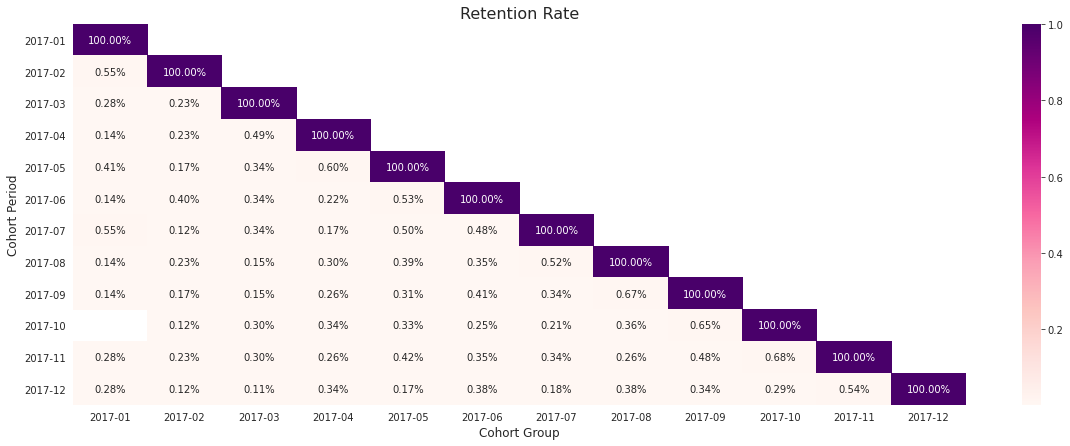

In [55]:
plt.figure(figsize=(20,7))
with sns.axes_style("whitegrid"):
    ax = sns.heatmap(customer_retention, annot=True,cmap='RdPu', fmt='.2%')
    ax.set_ylabel('Cohort Period', fontsize = 12)
    plt.yticks(rotation ='horizontal')
    ax.set_xlabel('Cohort Group', fontsize = 12)
    ax.set_title('Retention Rate', fontsize = 16)

### <a id="title6"> 6. Построить RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. </a>
Методология:
1. Для начала необходимо просчитать количество дней с момента последней покупки каждого из пользователей, показатель Recency. Так как наблюдения в датасете прерываются в 2018 году, финишной точкой буду считать последнюю дату в датасете с действиями по заказу. Измерения от текущей даты, на мой взгляд, сделает цифры более отдалёнными от реальности на момент выгрузки датасета. Взяла ранее созданный датасет с данными о покупателях и заказах, перевела customer_unique_id в индексы, так у некоторых пользователей несколько заказов и простая группировка по уникальному id клиента, выдала бы результат NaN. После этого создала колонку с дельтой между последним таймстемпом в датафрейме и последней датой покупки (order_approved_at). Далее перевела разницу в число, кратное дням для удобства дальнейшей работы. 
2. Так как клиенты довольно редко совершают покупки в качестве периода, по которому расчитано количество покупок, (Freqency) я взяла всю историю наблюдений. 
3. Для расчёта Monetary взяла сумму всех оплаченных покупок за историю наблюдений. 
4. Я разделила каждый параметр на 3 сегмента:
        *recency — в работе с временем логично опираться на понятные отрезки (месяцы, кварталы, полугодия, годы). Медиана наших наблюдений проходит близко к 1 году (341 день), 70% наблюдений в рамках 1 года, 30% наблюдений в рамках полугодия
            1 — 1-180 дней
            2 — 181-365 дней  
            3 — более 365 дней
        *frequency — 96,9% пользоватлелей имеет по 1 покупке, данный показатель имеет смысл разделить так:
            1 — более 1 покупки
            2 — 1 покупка
            3 — нет покупок (так как мы считаем только оплаченные покупки, то в этом сегменте пользователи, у которых была покупка, но не случилось полноценного покупательского опыта от момента выбора до момента использования товаров)
        *monetary — разнообразие данных и отсутствие привязки к чему-либо позволяет разделить данные просто на 3 сегмента по процентилям
            1 — высокие тратами (75 процентиль и выше)
            2 — средние траты (25-75 процентиль)
            3 — низкие траты (25 процентиль и выше)
Такое разделение даёт 27 (3^3) сегментов, некоторые из них можно объединить:  
**Top** — более 1 покупки, 1-180 дней, высокие траты (r 1, f 1, m 1). Клиенты с самой высокой ценностью, покупают чаще и больше всех  
**Loyal** — более 1 покупки, 1-180 дней, средние и низкие траты (r 1, f 1, m 2-3). Покупают часто, но сумма чека не такая высокая, как у Top  
**Recent** — 1 покупка,  1-180 дней (r 1, f 2, m 1-3). Совершили единственную покупку в последние полгода  
**Can Be Loyal** — более 1 покупки, 181-365 дней (r 2, f 1, m 1-3). Могут перейти в разряд Loyal или Top, если замотивировать их совершать покупки с более коротким промежутком времени между заказами  
**Potential** — 1 покупка, 181-365 дней, средний и высокий чек (r 2, f 2, m 1-2). Совершили одну покупку за период от полугода до года, чек при этом средний или выше среднего, нужно работать на удержание  
**Promising** — 1 покупка,  181-365 дней, низкий чек (r 2, f 2, m 3). Совершили одну покупку за период от полугода до года, чек при этом ниже среднего, нужно работать на удержание и повышение стоимости чека  
**Can't lose** — более 1 покупки, 365+ (r 3, f 1, m 1-3). Более года назад совершили больше 1 покупки, что превышает показатель 96,7% пользователей. Высокие риски потерять этих клиентов навсегда, необходимо работать над возвращением их активности  
**Hibernation** — 0-1 покупок, 365+ (r 3, f 2-3, m 1-3). Совершили 1 или 0 покупок с полным циклом более года назад
 

   [Перейти к описанию данных](#title0)

In [56]:
orders_customers[['order_purchase_timestamp', 
                  'order_approved_at', 
                  'order_delivered_carrier_date', 
                  'order_delivered_customer_date']].max()

order_purchase_timestamp        2018-10-17 17:30:18
order_approved_at               2018-09-03 17:40:06
order_delivered_carrier_date    2018-09-11 19:48:28
order_delivered_customer_date   2018-10-17 13:22:46
dtype: datetime64[ns]

In [57]:
last_timestamp = orders_customers['order_purchase_timestamp'].max()
orders_customers.set_index('customer_unique_id', inplace=True)

In [58]:
orders_customers['time_since_last_purchase'] = last_timestamp - orders_customers.groupby(level=0).order_approved_at.max()

In [59]:
orders_customers['time_since_last_purchase'] = round(orders_customers.time_since_last_purchase \
                                                     .apply(lambda x: x.total_seconds()) / 86400)

In [60]:
orders_customers['number_of_purchases'] = orders_customers.groupby(level=0).order_approved_at.count() \
                                                          .sort_values(ascending=False)

In [61]:
check_amount = order_items.groupby('order_id', as_index=False) \
                          .agg({'product_id': 'count', 'price': 'sum'}) \
                          .rename(columns={'product_id': 'number_of_products', 'price': 'check_amount'})

In [62]:
orders_customers.reset_index(inplace=True)

In [63]:
rfm_dataframe = orders_customers.merge(check_amount, how='inner', on='order_id') \
                                .drop(['customer_id', 
                                       'order_status', 
                                       'order_purchase_timestamp', 
                                       'order_approved_at', 
                                       'order_delivered_carrier_date', 
                                       'order_delivered_customer_date', 
                                       'order_estimated_delivery_date', 
                                       'customer_zip_code_prefix', 
                                       'customer_city', 
                                       'customer_state', 
                                       'weeks_in_current_month'], axis=1)

In [64]:
rfm_dataframe = rfm_dataframe.groupby('customer_unique_id') \
                             .agg({'time_since_last_purchase': 'min', 
                                   'number_of_purchases': 'sum', 
                                   'check_amount': 'sum'}) \
                             .rename(columns={'time_since_last_purchase': 'recency', 
                                              'number_of_purchases': 'frequency',
                                              'check_amount': 'monetary'}) \
                             .reset_index()

In [65]:
rfm_dataframe.recency.describe()

count    95407.000000
mean       287.123461
std        153.119378
min         44.000000
25%        163.000000
50%        268.000000
75%        396.000000
max        762.000000
Name: recency, dtype: float64

In [66]:
rfm_dataframe.recency.quantile([.3, .7])

0.3    183.0
0.7    362.0
Name: recency, dtype: float64

In [67]:
rfm_dataframe[rfm_dataframe.frequency == 1].shape[0] / rfm_dataframe.shape[0]

0.9690106895828967

In [68]:
monetary_quantile = rfm_dataframe.monetary.quantile([.25, .75]).to_dict()

In [69]:
def r_score(x):
    if x <= 180:
        return 1
    elif x <=365:
        return 2
    else:
        return 3    
def f_score(x):
    if x > 1:
        return 1
    elif x == 1:
        return 2
    else:
        return 3       
def m_score(x):
    if x > monetary_quantile[.75]:
        return 1
    elif x > monetary_quantile[.25]:
        return 2
    else:
        return 3

In [70]:
rfm_dataframe['r'] = rfm_dataframe.recency.apply(r_score)
rfm_dataframe['f'] = rfm_dataframe.frequency.apply(f_score)
rfm_dataframe['m'] = rfm_dataframe.monetary.apply(m_score)

In [71]:
rfm_dataframe['rfm'] = (rfm_dataframe.r.map(str) + rfm_dataframe.f.map(str) + rfm_dataframe.m.map(str)).map(int)

In [72]:
def segm(x):
    if x == 111:
        return 'top'
    elif x in range(112, 114):
        return 'loyal'
    elif x in range(211, 214):
        return 'can be loyal'
    elif x in range(221, 223):
        return 'potential'
    elif x in range(121, 124):
        return 'recent'
    elif x == 223:
        return 'promising'
    elif x in range(311, 314):
        return 'can\'t lose'
    elif x in range(331, 334) or x in range(321, 324):
        return 'hibernation'
    else:
        return 'none'

In [73]:
rfm_dataframe['segment'] = rfm_dataframe.rfm.apply(segm)

In [74]:
recency_counts = rfm_dataframe.groupby(['r', 'segment']) \
                              .agg({'customer_unique_id': 'count'}) \
                              .reset_index() \
                              .sort_values(by=['r', 'customer_unique_id'], ascending=[True, False]) \
                              .rename(columns={'r': 'recency'})

In [75]:
recency_counts['recency'] = recency_counts.recency.apply(lambda x: str(x).replace('3', '365+ days') \
                                                                         .replace('1', '1-180 days') \
                                                                         .replace('2', '181-365 days'))

In [76]:
frequency_counts = rfm_dataframe.groupby(['f', 'segment']) \
                              .agg({'customer_unique_id': 'count'}) \
                              .reset_index() \
                              .sort_values(by=['f', 'customer_unique_id'], ascending=[True, False]) \
                              .rename(columns={'f': 'frequency'})

In [77]:
frequency_counts['frequency'] = frequency_counts.frequency.apply(lambda x: str(x).replace('3', '0 purchases') \
                                                                         .replace('1', '1+ purchases') \
                                                                         .replace('2', '1 purchase'))

In [78]:
monetary_counts = rfm_dataframe.groupby(['m', 'segment']) \
                              .agg({'customer_unique_id': 'count'}) \
                              .reset_index() \
                              .sort_values(by=['m', 'customer_unique_id'], ascending=[True, False]) \
                              .rename(columns={'m': 'monetary'})

In [79]:
rfm_dataframe.monetary.quantile([.25, .75])

0.25     47.9
0.75    155.0
Name: monetary, dtype: float64

In [80]:
monetary_counts['monetary'] = monetary_counts.monetary.apply(lambda x: str(x).replace('3', '0-48 $') \
                                                                         .replace('1', '155+ $') \
                                                                         .replace('2', '49-154 $'))

In [81]:
fig = px.bar(recency_counts, x="segment", y="customer_unique_id",
             facet_col="recency",
             category_orders={"recency": ["1", "2", "3"]},
             title="Distribution by Recency",
             labels={'customer_unique_id':'Number of customers', 'segment': ''},
             template='simple_white', 
             color_discrete_sequence =['#4D3C77'])
fig.update_xaxes(tickangle=270)
fig.update_layout(width=900, height=400)
fig.show()
fig = px.bar(frequency_counts, x="segment", y="customer_unique_id",
             facet_col="frequency",
             category_orders={"frequency": ["1", "2", "3"]},
             title="Distribution by Frequency",
             labels={'customer_unique_id':'Number of customers', 'segment': ''},
             template='simple_white', 
             color_discrete_sequence =['#4D3C77'])
fig.update_xaxes(tickangle=270)
fig.update_layout(width=900, height=400)
fig.show()
fig = px.bar(monetary_counts, x="segment", y="customer_unique_id",
             facet_col="monetary",
             category_orders={"monetary": ["1", "2", "3"]},
             title="Distribution by Monetary",
             labels={'customer_unique_id':'Number of customers', 'segment': ''},
             template='simple_white', 
             color_discrete_sequence =['#4D3C77'])
fig.update_xaxes(tickangle=270)
fig.update_layout(width=900, height=400)
fig.show()

Дополнительным полем для анализа может быть география пользователей и покупок. С помощью такого инструмента можно дополнить портрет покупателя, посмотреть на объёмы продаж в каждом регионе в зависимости от географии достаки (возможно расширить партнёрскую сеть доставки), сравнить покупательскую способность региона (например, средний/медианный уровень дохода) и средний чек и т.д.  
В наших данных наибольшее количество покупок приходится на самый населённый штат Сан-Паулу, где проживает 21.6% всего начеления страны. В топ 3 по продажам так же входят штаты Рио-де-Жанейро и Минас-Жерайс. Эти штаты так же занимают 3 первых места по численности населения. На [графике](#choropleth_1) показано распространение географии продаж в зависимости от даты покупки. Однако такой график не учитывает количество населения и сравнивать продажи между регионами в абсолютных цифрах некорректно.  
Я добавила колонку с численностью населения в миллионах человек и вывела количество покупок на 1 миллион населения. Построила  [график](#choropleth_2) для количества покупок на 1 млн человек. Южные штаты всё ещё остаются в лидерах, однако теперь можно увидеть более объективную географию продаж.

In [82]:
geo_distribution = orders_customers.groupby(['customer_state', 'purchase_date'], as_index=False) \
                                   .agg({'customer_unique_id': 'count', 'number_of_purchases': 'sum'}) \
                                   .sort_values(by='purchase_date')

In [83]:
state_data = orders_customers.groupby('customer_state', as_index=False) \
                                   .agg({'customer_unique_id': 'count', 'number_of_purchases': 'sum'})

In [84]:
state_data['population, mil'] = [0.734, 3.121, 3.484, 0.670, 14.017, 8.452, 2.570, 3.515, 6.004, 
                            6.575, 19.597, 2.449, 3.035, 7.581, 3.767, 8.796, 3.118, 10.445, 
                            15.990, 3.168, 1.562, 0.451, 10.694, 6.248, 2.068, 41.262, 1.383]

In [85]:
state_data['num_of_purchases_per_mil_people'] = state_data.number_of_purchases / state_data['population, mil']

In [86]:
from urllib.request import urlopen

with urlopen('https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson') as response:
    brazil = json.load(response)

<a id='choropleth_1'></a>

In [87]:
fig = px.choropleth_mapbox(geo_distribution,
                    locations='customer_state',
                    geojson = brazil,
                    featureidkey='properties.sigla',
                    color= geo_distribution['number_of_purchases'],
                    color_continuous_scale= 'purpor',
                    title='Geography of purchases by month',
                    animation_frame='purchase_date')
fig.update_layout(
    margin={"l": 0, "r": 0, "t": 30, "b": 0},
    mapbox={
        'style': 'carto-positron',
        'zoom': 2.5,
        'center': {'lat': -14.2350, 'lon': -51.9253},
    },
)
fig.show()

<a id='choropleth_2'></a>

In [ ]:
fig = px.choropleth_mapbox(state_data,
                    locations='customer_state',
                    geojson = brazil,
                    featureidkey='properties.sigla',
                    color= state_data['num_of_purchases_per_mil_people'],
                    color_continuous_scale= 'purpor',
                    title='Geography of purchases depending on the number of people')
fig.update_layout(
    margin={"l": 0, "r": 0, "t": 30, "b": 0},
    mapbox={
        'style': 'carto-positron',
        'zoom': 2.5,
        'center': {'lat': -14.2350, 'lon': -51.9253},
    },
)
fig.show()